In [1]:
%matplotlib inline
import torch
from matplotlib import pyplot as plt
import numpy as np
import random
from IPython import display

#### 生成数据集

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

In [3]:
features[0]

tensor([0.8380, 2.2175])

C:\Users\WJT\AppData\Local\Temp/ipykernel_5000/2702163596.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


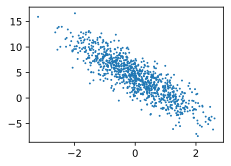

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

#### 读取数据

In [5]:
# 小批量数据生成器
def data_iter(batch_size, features, labels):
    '''
    input: 
            batch_size: int
            features  : tensor
            labels    : tensor
    output:
            此函数是一个生成器，直接用于for循环
            generator
    '''
    num_examples = len(features)# 样本数
    # 生成随机索引，实现样本选取的随机性
    indices = list(range(num_examples))
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # j为选取的batch_size个样本的下标集合
        j = torch.LongTensor(indices[i:min(i+batch_size, num_examples)])
        # yield类似于return，但是yield在每个循环返回一次，生成一个生成器(generator)
        # 因此此函数不能被简单调用，而是只能被当作一个迭代器被for循环迭代
        yield features.index_select(0, j),labels.index_select(0, j)

In [6]:
# test
batch_size = 5
for x, y in data_iter(batch_size, features, labels):
    print(x,'\n',y)
    break

tensor([[-1.0775, -0.7594],
        [ 0.5320,  0.6340],
        [ 1.0941,  1.5596],
        [ 1.1606, -0.8143],
        [-0.1760,  0.3028]]) 
 tensor([4.6176, 3.1108, 1.0834, 9.2924, 2.8222])


#### 初始化模型参数  

将权重初始化为均值为0，标准差为0.01的正态随机数，偏差初始化为0

In [7]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)
# 由于要求这些参数梯度来训练，因此要使autograd打开
w.requires_grad_(True);
b.requires_grad_(True);

#### 定义模型

In [15]:
def linreg(x,w,b):
    # torch.mm == @
    return torch.mm(x, w) + b

#### 定义损失函数


In [9]:
def squared_loss(y_hat, y):
    return (y_hat-y.view(y_hat.size())) ** 2/2

#### 定义优化算法

小批量随机梯度下降法

In [17]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr*param.grad/batch_size

#### 训练模型

In [18]:
# 定义超参数
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 5
for epoch in range(num_epochs): # 对于每一个迭代周期
    for x, y in data_iter(batch_size, features,labels): # 对于每一个小批量样本
        l = loss(net(x, w, b), y).sum() # 计算该批量的损失值
        l.backward()
        sgd([w, b], lr, batch_size)
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch+1, train_l.mean().item()))

epoch 1, loss 0.000140
epoch 2, loss 0.000051
epoch 3, loss 0.000051


In [22]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0001],
        [-3.3999]], requires_grad=True)
4.2 
 tensor([4.1997], requires_grad=True)
